<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Let's look at truncation of the SVD spectrum as a regularization device

Recall that regularization refers to any approach that makes an illposed/underdetermined parameter estimation problem solvable.  Therefore, when you manually reduce the number of parameters such as zones you are doing a type of regularization.  

Singular Value Decomposition can be thought of as operating in a similar fashion but is automated, and more clever.  Using the Jacobian matrix, it reduces the number of base parameters by making linear combinations of the base parameters.  Thus two perfectly correlated parameters become 1 combined parameter, which helps give a unique solution to the parameter estimation problem. Those linear combinations (__=singular values__) that are in the noise (__=null space__) get truncated (__=removed from the parameter estimation process__).  This means that insensitive parameters don't adversely affect the parameter estimation process.  Those linear combinations that remain (__=solution space__) are then used to solve the parameters estimation problem.  

Truncated SVD approach makes for a parameter estimation process that is __*unconditionally stable*__, which means it is guaranteed to be well-posed, and solvable. But the number of singular values also controls, in a somewhat brute force way, the degree of parameter smoothing and fit. The key to stability and degree of smoothing is this truncation process, which we'll dig into here.


In [1]:
import os, shutil
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
import pestools as pt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    newln='\n'
else:
    ppp='./pestpp'
    newln='\r\n'
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

setting random seed


## We can work with the pilot points model, so we will copy over the pilot points files

In [2]:
base_dir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];
if not os.path.exists('base_pp_dir'):
    os.mkdir('base_pp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_pp_dir',cf)) for cf in os.listdir(base_dir)];
# Since this is a sythetic example, we can load up the true K field to compare our answers to 
HK_truth = np.loadtxt(os.path.join('..','..','models','Freyberg','Freyberg_Truth','hk.truth.ref'))
# ibound can be used to mask inactive areas
ib = np.loadtxt('ibound.ref')
HK_truth[ib==0] = np.nan
forecasts_true = pd.read_csv(os.path.join('..','..','models','Freyberg','Freyberg_Truth','forecasts_true.csv'), index_col=0)

## Set up the couple functions we made for pilot points to visualize results

In [3]:
def update_K(inpstname):
    optpst = pyemu.Pst(inpstname + '.pst')
    # reset the parameter values using the best parameters from the last run
    optpst.parrep(inpstname + '.bpa')
    # set NOPTMAX=0 to run the model just a single time
    optpst.control_data.noptmax=0
    # write out the PST file with a new name
    optpst.write(inpstname + '_opt.pst')
    # run the new version of the model
    os.system('{0} {1}_opt.pst'.format(ppp, inpstname))

In [4]:
def plot_K_results(inpstname):
    HK_best = np.loadtxt('hk.ref')
    HK_best[ib==0] = np.nan
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
    im1=ax1.imshow(HK_truth, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    cbar1 = plt.colorbar(im1, cax=cax1,format="%.2f")

    im2=ax2.imshow(HK_best, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2,  format="%.2f")

    im3=ax3.imshow(HK_best, interpolation='nearest', cmap='viridis')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="20%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3,  format="%.2f")
    plt.tight_layout()
    plt.savefig(inpstname + 'HK_.pdf')
    
    plt.figure()
    inphi = pd.read_csv(inpstname +'.iobj')
    inphi[['total_phi','measurement_phi', 'regularization_phi']].plot()
    plt.gca().set_yscale('log')
    plt.ylabel('PHI')
    plt.xlabel('Iteration Number')

# First, let's make the Jacobian matrix at the starting conditions

In [5]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.control_data.noptmax=-1
inpst.write('freyberg_jac.pst')
shutil.copy2('freyberg_jac.pst',os.path.join('base_pp_dir','freyberg_jac.pst'))

'base_pp_dir/freyberg_jac.pst'

In [6]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_jac.pst",20,slave_root='.',port=4004,master_dir='.')

# in `pyemu` we can read in the  Jacobian and, if we form the Schur complement object, we also get $\mathbf{X}^T\mathbf{Q}\mathbf{X}$

In [7]:
injac = pyemu.Schur('freyberg_jac.jcb')

## now let's look at the singular value spectrum

In [8]:
U,S,V = np.linalg.svd(injac.xtqx.df())

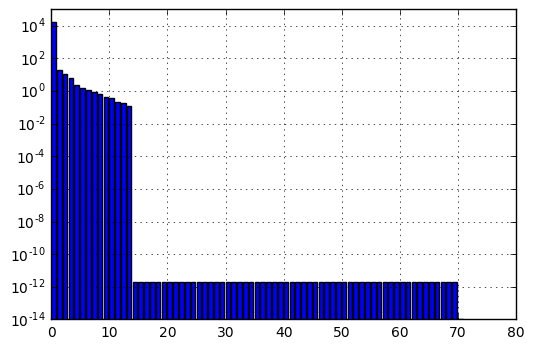

In [9]:
plt.bar(range(len(S)),S)
plt.yscale('log')
plt.grid('on')

# So what if we only use parameters comprising the first 2 singular vectors?

In [10]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')

In [11]:
inpst.pestpp_options['n_iter_super'] = 100
inpst.pestpp_options['max_n_super'] = 2

inpst.pestpp_options

{'forecasts': 'rivflux_fore,travel_time,fr03c16,fr04c9',
 'max_n_super': 2,
 'n_iter_base': '-1',
 'n_iter_super': 100,
 'super_eigthres': '1.0e-8'}

In [12]:
inpst.write('freyberg_TSVD.pst')
shutil.copy2('freyberg_TSVD.pst',os.path.join('base_pp_dir','freyberg_TSVD.pst'))

'base_pp_dir/freyberg_TSVD.pst'

In [13]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_TSVD.pst",20,slave_root='.',port=4004,master_dir='.')

In [14]:
indf = pd.read_csv('freyberg_TSVD.iobj')

In [15]:
indf

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,head_fore,flux_fore,travel_fore,head_cal,flux_cal,regulhkpp
0,0,0,61.9328,61.9328,0.000000e+00,0,0,0,57.9548,3.978030,0.000000e+00
1,1,80,29.8859,29.8190,6.684940e-02,0,0,0,28.3146,1.504450,6.684940e-02
2,2,90,27.4224,27.4220,4.588060e-04,0,0,0,27.2926,0.129348,4.588060e-04
3,3,102,27.4202,27.4202,3.151190e-06,0,0,0,27.3172,0.103015,3.151190e-06
4,4,115,27.4201,27.4201,2.802140e-08,0,0,0,27.3168,0.103337,2.802140e-08


In [16]:
update_K('freyberg_TSVD')

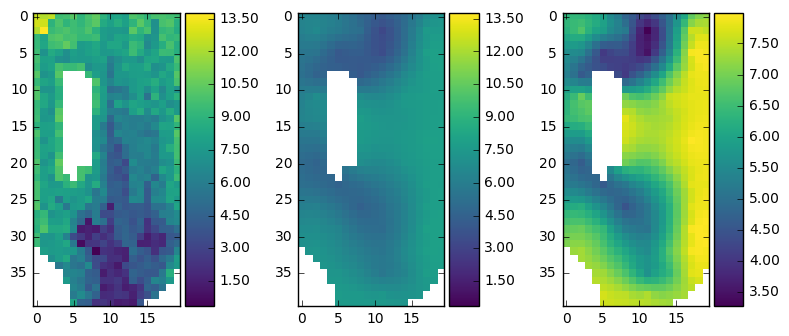

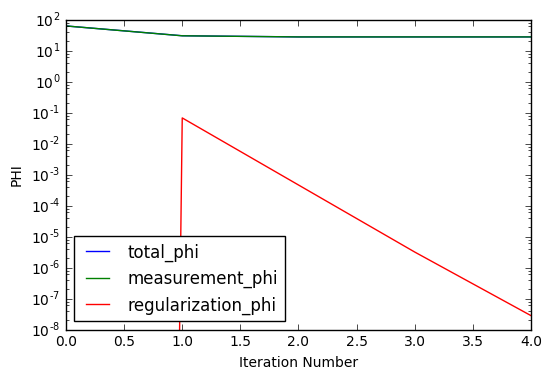

In [17]:
plot_K_results('freyberg_TSVD')

# How does this compare with the pilot points solution with low PHIMLIM?

In [35]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.regul_lines

['   2.500000e-05       2.625000e-05     0.1000000\n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [18]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_pp_reg.pst",20,slave_root='.',port=4004,master_dir='.')

In [19]:
update_K('freyberg_pp_reg')

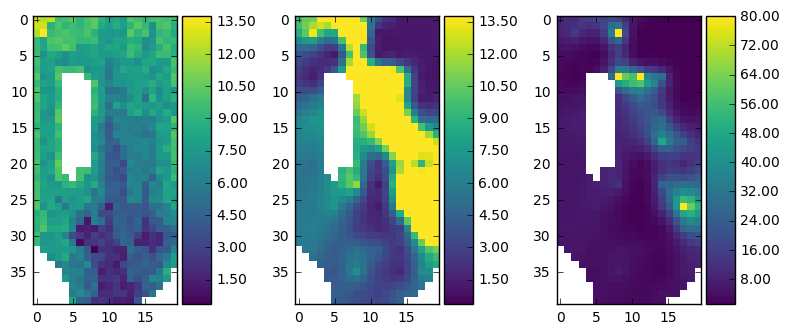

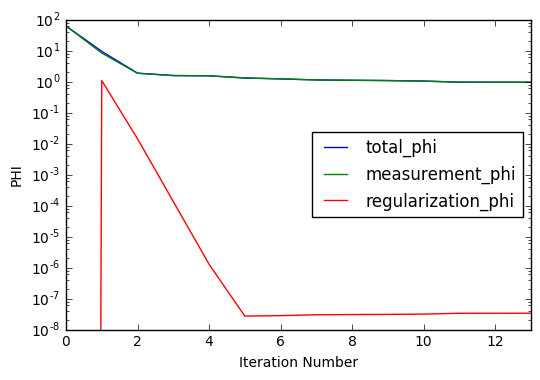

In [20]:
plot_K_results('freyberg_pp_reg')